In [1]:
# What GPU I have
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug  7 21:45:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import random

random.seed(123)

random.random()

0.052363598850944326

In [3]:

random.random()

0.08718667752263232

In [4]:
import tensorflow as tf 
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import *
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import *

import keras
from keras.layers import Dropout, MaxPooling1D, Dense, Flatten, SimpleRNN, LSTM, Bidirectional

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
X_train = pd.read_csv("/content/drive/My Drive/Thesis/Data/Daily/X_train_days.csv", sep = ';', encoding = 'latin1', header = None)
y_train = pd.read_csv("/content/drive/My Drive/Thesis/Data/Daily/y_train_days.csv", sep = ';', encoding = 'latin1', header = None)
X_test = pd.read_csv("/content/drive/My Drive/Thesis/Data/Daily/X_test_days.csv", sep = ';', encoding = 'latin1', header = None)
y_test = pd.read_csv("/content/drive/My Drive/Thesis/Data/Daily/y_test_days.csv", sep = ';', encoding = 'latin1', header = None)

In [7]:
y_train = y_train[X_train.sum(axis = 1) != 0]
X_train = X_train[X_train.sum(axis = 1) != 0]
# Remove all rows which have a sum of zero accross the row

In [8]:
X_train_scaled_m_m = X_train.sub(X_train.min(axis=1), axis=0).divide(X_train.max(axis=1).sub(X_train.min(axis=1)), axis=0)

X_test_scaled_m_m = X_test.sub(X_test.min(axis=1), axis=0).divide(X_test.max(axis=1).sub(X_test.min(axis=1)), axis=0)

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [10]:
# Padding, done to have weeks line up nicely
X_train_scaled_padded = pd.concat([pd.DataFrame(np.zeros((174,5)), index = X_train_scaled_m_m.index), X_train_scaled_m_m, pd.DataFrame(np.zeros((174,1)),index = X_train_scaled_m_m.index)], axis=1)
X_test_scaled_padded = pd.concat([pd.DataFrame(np.zeros((59,5)), index = X_test_scaled_m_m.index), X_test_scaled_m_m, pd.DataFrame(np.zeros((59,1)),index = X_test_scaled_m_m.index)], axis=1)

In [11]:
img_0 = np.array(X_train_scaled_padded.iloc[0]).reshape(-1,7) # Example of how one time series turns into image

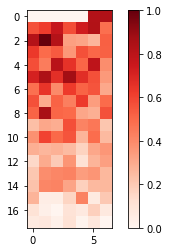

In [12]:
plt.imshow(img_0, cmap = "Reds")
plt.colorbar()

In [13]:
img_0.shape[1]
np.zeros((img_0.shape[1], img_0.shape[0]))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [14]:
img_1 = np.zeros((img_0.shape[1], img_0.shape[0]))
print(img_1.shape)
for r in np.arange(img_0.shape[0]):
  for c in np.arange(img_0.shape[1]):
    img_1[c,r] = img_0[r,c]

(7, 18)


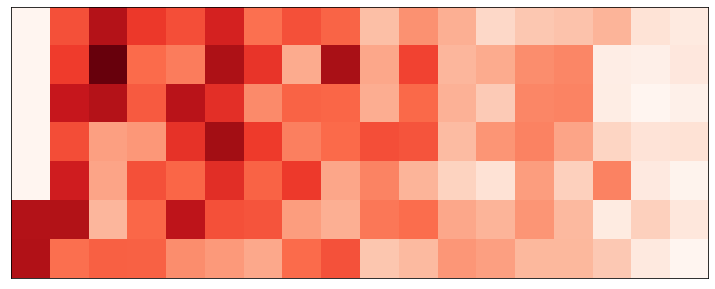

In [15]:
plt.figure(figsize = (12.5,5))
plt.imshow(img_1, cmap = "Reds")
#plt.axis("off")
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig("CNN_data.png", bbox_inches='tight')

In [16]:
X_train_images = np.array(X_train_scaled_padded).reshape(174, -1, 7)
X_test_images = np.array(X_test_scaled_padded).reshape(59, -1, 7)

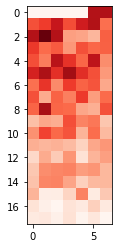

In [17]:
plt.imshow(X_train_images[0], cmap = "Reds")

In [18]:
X_train_images.shape

(174, 18, 7)

In [19]:
(y_train == 1).shape

(174, 1)

In [20]:
no_hpumps = X_train_images[(y_train == 0)[0].values,0:,0:]
yes_hpumps = X_train_images[(y_train == 1)[0].values,0:,0:]

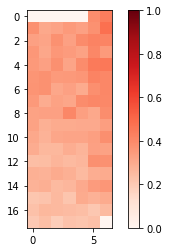

In [21]:
plt.imshow(np.median(no_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
plt.colorbar()
# Mean of places with no heat pumps

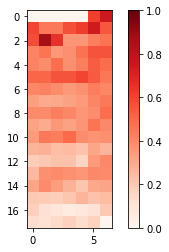

In [22]:
plt.imshow(np.median(yes_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
# Mean of places with heat pumps
plt.colorbar()

[Text(0, 0, 'M'),
 Text(0, 0, 'T'),
 Text(0, 0, 'W'),
 Text(0, 0, 'T'),
 Text(0, 0, 'F'),
 Text(0, 0, 'S'),
 Text(0, 0, 'S')]

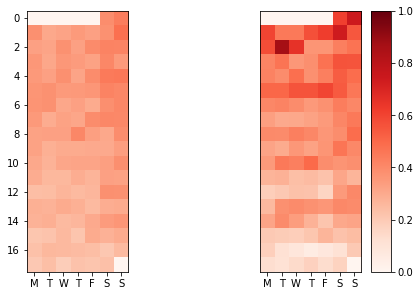

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = True)
im1 = ax1.imshow(np.median(no_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
im2 = ax2.imshow(np.median(yes_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
ax2.yaxis.set_visible(False)
fig.colorbar(im2)
#labels1 = [item.get_text() for item in ax1.get_xticklabels()]
#labels2 = [item.get_text() for item in ax2.get_xticklabels()]
day = 0
#for label in labels1:
#  labels1[day] = str(day)
#  day += 1

#ax1.set_xticklabels(labels1)
ax1.set_xticks([0,1,2,3,4,5,6])
ax1.set_xticklabels(["M","T","W","T","F","S","S"])
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels(["M","T","W","T","F","S","S"])
#fig.tight_layout()

In [24]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import tensorflow
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [25]:

from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

In [26]:
set_random_seed(123)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(18,7,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [27]:
set_random_seed(123)
model.compile(loss='binary_crossentropy',optimizer=SGD(momentum=0.5, decay=0.0004), metrics = ["accuracy"])


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 7, 32)         320       
                                                                 
 batch_normalization (BatchN  (None, 18, 7, 32)        128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 3, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 3, 32)          9248      
                                                                 
 batch_normalization_1 (Batc  (None, 9, 3, 32)         128       
 hNormalization)                                                 
                                                        

In [29]:
from tensorflow.keras.models import load_model

In [30]:
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 100)
mc = ModelCheckpoint('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Daily/best_untuned_model.h5', monitor = "val_loss", mode = "min", save_best_only = True)

In [31]:
set_random_seed(123)
history = model.fit(X_train_images, y_train, epochs = 1000, validation_split=0.1, batch_size = 32, callbacks = [es, mc])

Epoch 1/1000
5/5 [==============================] - 13s 335ms/step - loss: 0.6576 - accuracy: 0.6346 - val_loss: 0.6755 - val_accuracy: 0.6667
Epoch 2/1000
5/5 [==============================] - 0s 53ms/step - loss: 0.3591 - accuracy: 0.8462 - val_loss: 0.6754 - val_accuracy: 0.6667
Epoch 3/1000
5/5 [==============================] - 0s 31ms/step - loss: 0.2901 - accuracy: 0.8782 - val_loss: 0.6801 - val_accuracy: 0.6111
Epoch 4/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.2233 - accuracy: 0.9487 - val_loss: 0.6869 - val_accuracy: 0.6667
Epoch 5/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.1993 - accuracy: 0.9487 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 6/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1568 - accuracy: 0.9679 - val_loss: 0.6950 - val_accuracy: 0.3889
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - loss: 0.1321 - accuracy: 0.9615 - val_loss: 0.6973 - val_accuracy: 0.4444
Epoch 8/1000

In [32]:
model.evaluate(X_test_images, y_test)

2/2 [==============================] - 0s 15ms/step - loss: 0.5671 - accuracy: 0.7966


[0.5670729279518127, 0.7966101765632629]

In [33]:
# load the saved model
saved_model = load_model('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Daily/best_untuned_model.h5')

In [34]:
saved_model.evaluate(X_test_images, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.4420 - accuracy: 0.8136


[0.44199416041374207, 0.8135592937469482]

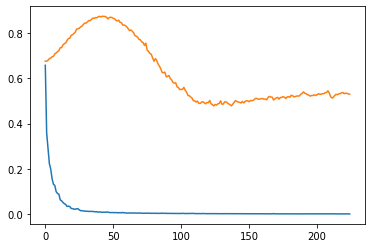

In [35]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [36]:
# OPTIMIZATION

In [37]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [38]:
def create_model(neurons, optimizer, learning_rate, activation, batch_norm, Conv_layers):
  opt_D = {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate), 'RMSprop': RMSprop(learning_rate=learning_rate)}
  opt = opt_D[optimizer]
  nn = Sequential()
  for i in np.arange(0, Conv_layers):
    #if i < LSTM_layers - 1:
    nn.add(Conv2D(32, (3, 3), input_shape=(18,7,1), padding='same', activation=activation))
    if batch_norm == True:
      nn.add(BatchNormalization())
    #if i == LSTM_layers - 1:
    #    nn.add(LSTM(neurons, input_shape=(120,1), return_sequences= False))
    #    nn.add(Dropout(dropout_rate))
  nn.add(Flatten()) 
  nn.add(Dense(1, activation='sigmoid'))
  nn.compile(optimizer= opt, loss='binary_crossentropy', metrics= ["accuracy"])
  return nn

In [39]:
create_model(neurons = 128, optimizer = "Adam", learning_rate = 0.001, activation = "relu", batch_norm = True, Conv_layers = 1).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 18, 7, 32)         320       
                                                                 
 batch_normalization_2 (Batc  (None, 18, 7, 32)        128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 4032)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4033      
                                                                 
Total params: 4,481
Trainable params: 4,417
Non-trainable params: 64
_________________________________________________________________


In [40]:
es1 = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)
mc1 = ModelCheckpoint('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Daily/best_tuned_model.h5', monitor = "val_loss", mode = "min", save_best_only = True)

In [41]:
random.seed(123)
set_random_seed(123)
model = KerasClassifier(build_fn=create_model, verbose = 0, callbacks = [es1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
%%time
random.seed(123)
set_random_seed(123)
import logging, sys
logging.disable(sys.maxsize)
neurons_L = [8,16,32, 128]
opt_L = ["Adam", "SGD", "RMSprop"]
lr_L = [ 0.0001, 0.001]
activation_L = ['relu', 'tanh']#, 'tanh']#, "selu"]
batch_norm_L = [True, False]
Conv_layers_L = [1, 2, 4]#,5,6,7]
batch_size_L = [32, 64]#, 64]#, 128]
epochs_L = [200]
param_grid = dict(neurons=neurons_L, optimizer = opt_L, learning_rate = lr_L, activation = activation_L, batch_norm = batch_norm_L, Conv_layers = Conv_layers_L, batch_size = batch_size_L, epochs = epochs_L )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring = "accuracy", verbose = 10 )
results = grid.fit(X_train_images, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 1min 6s, sys: 6.41 s, total: 1min 12s
Wall time: 1h 33min 3s


In [ ]:
results.cv_results_

{'mean_fit_time': array([ 8.59354647,  5.78493166,  7.10659115,  6.08098841,  5.80837075,
         8.27952282,  6.06261675,  5.82438413,  8.3702898 ,  6.11367138,
         5.94331209,  8.34009202,  4.88868459,  6.03054953,  6.97101045,
         6.88279144,  5.82168976,  7.8684113 ,  5.43868526,  5.98112535,
         6.74618864,  5.97346052,  5.74105922,  7.87169607,  4.28489256,
         3.21750116,  4.9464705 ,  3.56700158,  3.58934792,  4.63805127,
         5.9670101 ,  4.15149013,  4.44016155,  4.08922092,  4.36433824,
         4.61835313,  4.06374756,  5.33164096,  4.48842041,  4.29153721,
         4.66074999,  4.45034607,  4.20365302,  4.25402522,  4.37619877,
         4.43575835,  4.01598159,  5.50391142,  5.27693899,  5.85498063,
         7.8167634 ,  5.42979693,  5.57602612,  6.35219606,  6.18088078,
         5.19810057,  7.61334236,  5.44314647,  6.11211419,  6.22172077,
         5.87314979,  5.51353884,  6.22994637,  6.16515311,  5.22627878,
         6.10858774,  5.67912086, 

In [ ]:
results.best_params_

{'Conv_layers': 2,
 'activation': 'relu',
 'batch_norm': False,
 'batch_size': 64,
 'epochs': 200,
 'learning_rate': 0.0001,
 'neurons': 32,
 'optimizer': 'Adam'}

In [ ]:
results.best_score_

0.9080459770114943

In [ ]:
np.array(results.cv_results_['params'])[np.argsort(-1*results.cv_results_["mean_test_score"])]#[np.argsort(results.cv_results_["mean_test_score"])]

array([{'Conv_layers': 2, 'activation': 'relu', 'batch_norm': False, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 32, 'optimizer': 'Adam'},
       {'Conv_layers': 1, 'activation': 'relu', 'batch_norm': False, 'batch_size': 32, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 16, 'optimizer': 'Adam'},
       {'Conv_layers': 2, 'activation': 'relu', 'batch_norm': False, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 8, 'optimizer': 'Adam'},
       {'Conv_layers': 4, 'activation': 'relu', 'batch_norm': True, 'batch_size': 32, 'epochs': 200, 'learning_rate': 0.001, 'neurons': 32, 'optimizer': 'RMSprop'},
       {'Conv_layers': 2, 'activation': 'relu', 'batch_norm': False, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 8, 'optimizer': 'RMSprop'},
       {'Conv_layers': 1, 'activation': 'relu', 'batch_norm': False, 'batch_size': 32, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 16, 'optimizer': 'RMSprop'},
       {'Co

In [ ]:
-1*np.sort(-1*results.cv_results_["mean_test_score"])

array([0.90804598, 0.90229885, 0.90229885, 0.90229885, 0.90229885,
       0.89655172, 0.89655172, 0.89655172, 0.89655172, 0.89655172,
       0.89655172, 0.89655172, 0.8908046 , 0.8908046 , 0.8908046 ,
       0.8908046 , 0.8908046 , 0.88505747, 0.88505747, 0.88505747,
       0.88505747, 0.88505747, 0.88505747, 0.88505747, 0.88505747,
       0.88505747, 0.88505747, 0.88505747, 0.88505747, 0.88505747,
       0.88505747, 0.88505747, 0.88505747, 0.88505747, 0.88505747,
       0.88505747, 0.88505747, 0.87931034, 0.87931034, 0.87931034,
       0.87931034, 0.87931034, 0.87931034, 0.87931034, 0.87931034,
       0.87931034, 0.87931034, 0.87931034, 0.87931034, 0.87931034,
       0.87931034, 0.87931034, 0.87931034, 0.87931034, 0.87931034,
       0.87931034, 0.87356322, 0.87356322, 0.87356322, 0.87356322,
       0.87356322, 0.87356322, 0.87356322, 0.87356322, 0.87356322,
       0.87356322, 0.87356322, 0.87356322, 0.87356322, 0.87356322,
       0.87356322, 0.87356322, 0.87356322, 0.87356322, 0.87356

In [42]:
set_random_seed(123)
#best_tuned_model = create_model(neurons = results.best_params_["neurons"], optimizer = results.best_params_["optimizer"], activation = results.best_params_["activation"], batch_norm = results.best_params_["batch_norm"], Conv_layers = results.best_params_["Conv_layers"], learning_rate = results.best_params_["learning_rate"])
#best_tuned_model = create_model(neurons = 16, optimizer = "SGD", activation = "relu", batch_norm = True, Conv_layers = 1, learning_rate = 0.001)
best_tuned_model = create_model(neurons = 32, optimizer = "RMSprop", activation = "relu", batch_norm = False, Conv_layers = 4, learning_rate = 0.001)

In [43]:
best_tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 18, 7, 32)         320       
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 7, 32)         9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 7, 32)         9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 7, 32)         9248      
                                                                 
 flatten_2 (Flatten)         (None, 4032)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4033      
                                                                 
Total params: 32,097
Trainable params: 32,097
Non-trai

In [44]:
epochs = 300
verbose = 1

In [45]:
%%time
set_random_seed(123)
history_best_tuned = best_tuned_model.fit(np.array(X_train_images), y_train, epochs=epochs, verbose=verbose, batch_size = 32, validation_split=0.1, callbacks = [es1, mc1])

Epoch 1/300
5/5 [==============================] - 1s 130ms/step - loss: 0.7404 - accuracy: 0.5192 - val_loss: 0.6530 - val_accuracy: 0.6667
Epoch 2/300
5/5 [==============================] - 0s 9ms/step - loss: 0.6570 - accuracy: 0.5962 - val_loss: 0.6702 - val_accuracy: 0.3889
Epoch 3/300
5/5 [==============================] - 0s 20ms/step - loss: 0.5744 - accuracy: 0.7756 - val_loss: 0.6426 - val_accuracy: 0.4444
Epoch 4/300
5/5 [==============================] - 0s 21ms/step - loss: 0.4726 - accuracy: 0.7756 - val_loss: 0.4637 - val_accuracy: 0.7222
Epoch 5/300
5/5 [==============================] - 0s 18ms/step - loss: 0.4200 - accuracy: 0.7949 - val_loss: 0.3476 - val_accuracy: 0.9444
Epoch 6/300
5/5 [==============================] - 0s 10ms/step - loss: 0.2990 - accuracy: 0.8846 - val_loss: 0.4133 - val_accuracy: 0.7778
Epoch 7/300
5/5 [==============================] - 0s 18ms/step - loss: 0.2873 - accuracy: 0.8782 - val_loss: 0.2858 - val_accuracy: 0.9444
Epoch 8/300
5/5 [===

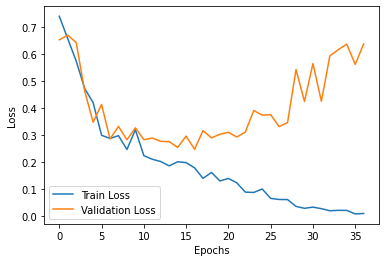

In [46]:
plt.figure()
plt.plot(history_best_tuned.history["loss"], label = "Train Loss")
plt.plot(history_best_tuned.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

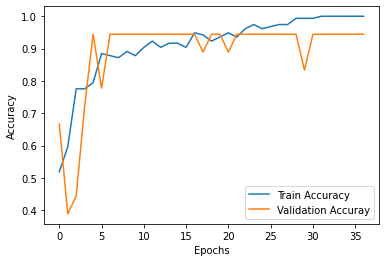

In [47]:
plt.figure()
plt.plot(history_best_tuned.history["accuracy"], label = "Train Accuracy")
plt.plot(history_best_tuned.history["val_accuracy"], label = "Validation Accuray")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [48]:
best_tuned_saved_model = load_model('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Daily/best_tuned_model.h5')

In [49]:
best_tuned_saved_model.evaluate(X_train_images, y_train)

6/6 [==============================] - 0s 6ms/step - loss: 0.1467 - accuracy: 0.9483


[0.14665809273719788, 0.9482758641242981]

In [50]:
best_tuned_saved_model.evaluate(X_test_images, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 0.2563 - accuracy: 0.8644


[0.25627195835113525, 0.8644067645072937]

P-R AUC 0.9711261460466795
P-R AUC 0.9711981566820277


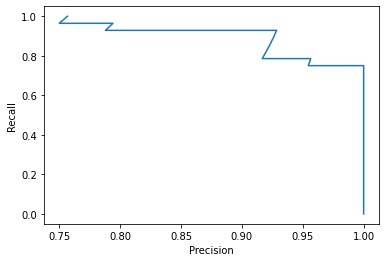

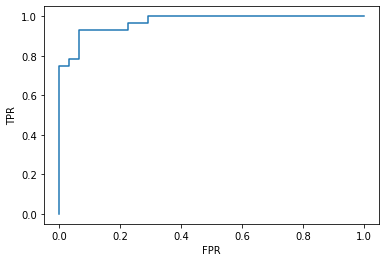

In [52]:

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = best_tuned_saved_model.predict(X_test_images).ravel()
y_test_pr = y_test[np.isnan(probs)==False]
probs = probs[np.isnan(probs)==False]
precisions, recalls, threshholds = precision_recall_curve(y_test_pr, probs)
plt.figure()
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
print("P-R AUC", auc( recalls, precisions))
fpr, tpr, thresholds = roc_curve(y_test_pr, probs, pos_label=1)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
print("ROC AUC", auc( fpr, tpr))